[Tensorbard로 모델, 데이터, 학습 시각화](https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html)

`torchvision.datasets` 의 Fashion-MNIST dataset으로 코드 진행

학습 목적
1. 데이터 읽고 변환
2. Tensorboard 설정
3. Tensorboard 기록
4. Tensorboard 이용해서 모델 구조 살펴보기
5. 코드 추가 $→$ 시각화의 대화식 버전 만들기
    
    - 학습 데이터를 검사하는 방법
    - 학습에 따른 모델의 성능을 추적하는 방법
    - 학습이 완료된 모델의 성능을 평가하는 방법


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transform
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

# datasets
trainset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=True,
    transform=transform
)
testset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=False,
    transform=transform
)

# dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

# 분류 결과를 위한 상수
classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot',
)

# 이미지를 보여주기 위한 헬퍼 함수
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)

    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()

    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

/Users/yang-uidong/opt/anaconda3/envs/torch_practice/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/yang-uidong/opt/anaconda3/envs/torch_practice/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <A770339A-37C9-36B2-84FE-4125FBE26FD6> /Users/yang-uidong/opt/anaconda3/envs/torch_practice/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <B5DCF36B-AC07-3EF2-A997-D38A25D2CCE2> /Users/yang-uidong/opt/anaconda3/envs/torch_practice/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


100%|██████████| 26421880/26421880 [00:43<00:00, 614020.81it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 37626.05it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:19<00:00, 230887.09it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8343229.13it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [4]:
# optimizer, criterion 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 1. TensorBoard 설정

In [5]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

### 2. TensorBoard에 기록하기

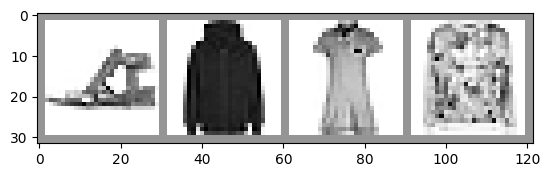

In [6]:
# make_grid 를 사용해서 grid 사용

dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 그리드 생성
img_grid = torchvision.utils.make_grid(images)

# 이미지 보여주기
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록
writer.add_image('four_fashion_mnist_images', img_grid)

In [10]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### 3. TensorBoard 를 사용해서 모델 살펴보기

In [9]:
writer.add_graph(net, images)
writer.close()